## Задание

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

- Был ли эксперимент успешен в целом.
- Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

from tqdm.auto import tqdm

from multipy.fwer import holm_bonferroni, bonferroni
from statsmodels.stats.multitest import multipletests

from statsmodels.stats.proportion import proportions_ztest

## 1. Подготовка данных

In [2]:
users_control_1 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_control_1.csv', sep=';')
users_control_2 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_control_2.csv', sep=';')

transactions_control_1 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_control_1.csv', sep=';',
                                     parse_dates=['joined_at', 'paid_at']).dropna(axis='index', how='any', subset=['uid'])

transactions_control_2 = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_control_2.csv', sep=';',
                                     parse_dates=['joined_at', 'paid_at']).dropna(axis='index', how='any', subset=['uid'])

users_test = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/users_test.csv', sep=';')

transactions_test = pd.read_csv('https://stepik.org/media/attachments/lesson/409320/transactions_test.csv', sep=';',
                                parse_dates=['joined_at', 'paid_at'])

users_control_1.sample(5)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
546,892425648,16,545,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,19,20",1,18,46,11,1.0,NaN,0
1299,891911235,48,571,NaN,France,"1,2,3,5,6,8,9,10,12,13,14,15,16,17,19,20,21",1,45,51,14,NaN,NaN,0
4336,891905022,38,200,NaN,Argentina,"1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,21",1,20,50,5,NaN,NaN,0
2734,891508620,35,600,NaN,United States of America,NaN,1,32,38,15,NaN,NaN,0
3674,891719328,48,200,NaN,Portugal,"1,2,3,4,5,7,8,14",1,45,51,15,1.0,NaN,0


Соединим попарно данные о плательщиках во всех трех группах.

In [3]:
transactions_control_1.uid = transactions_control_1.uid.astype(int)
transactions_control_2.uid = transactions_control_2.uid.astype(int)

In [4]:
res_control_1 = pd.merge(transactions_control_1, users_control_1, how="right", on=["uid", "uid"])
res_control_2 = pd.merge(transactions_control_2, users_control_2, how="right", on=["uid", "uid"])
res_test = pd.merge(transactions_test, users_test, how="right", on=["uid", "uid"])
res_control_1['revenue'].fillna(0, inplace=True)
res_control_2['revenue'].fillna(0, inplace=True)
res_test['revenue'].fillna(0, inplace=True)
res_control_1.sample(5)

,uid,country_x,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,country_y,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
1092,892285764,NaN,NaT,NaT,0.0,NaN,NaN,NaN,28,333,NaN,Portugal,"1,2,3,4,5,6,7,8,10,12,13,14,15,16,17,18,20,21,...",1,25,31,3,NaN,NaN,0
1023,891951798,United States of America,2017-10-24 05:41:00,2017-10-31 07:41:00,9087.0,147.0,trial_vip_popup,trial_premium,55,0,NaN,United States of America,"1,2,3,4,6,7,9,10,12,13,14,16,18,19,21",1,50,58,0,1.0,1.0,9087
1244,892101909,France,2017-10-21 03:28:00,2017-10-21 03:39:00,6422.0,0.0,none,premium_no_trial,25,531,2.0,France,"1,2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,19,21,2...",1,22,28,32,1.0,1.0,14508
3110,892069554,United Kingdom (Great Britain),2017-10-21 19:11:00,2017-03-11 10:44:00,6305.0,19.0,empty_likes,coins,47,185,8.0,United Kingdom (Great Britain),"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,38,1414,NaN,NaN,59267
1012,891693753,Turkey,2017-10-29 15:24:00,2017-06-11 22:30:00,3432.0,147.0,promo_09,premium_no_trial,24,311,50.0,Turkey,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,18,40,478,1.0,1.0,13026


In [5]:
del res_control_1['country_x']
del res_control_2['country_x']
del res_test['country_x']

In [6]:
res_test.query('revenue != 0 and total_revenue == 0').shape[0]

0

In [7]:
res_control_1.query('revenue != 0 and total_revenue == 0').shape[0]

1

In [8]:
res_control_2.query('revenue != 0 and total_revenue == 0').shape[0]

0

В ходе проверки данных был обнаружен пользователь, производивший транзакции, но не имеющий записи о нормированной выручке.

In [9]:
# исправил значение total_revenue пользователю, запись о транзакции одна, значит по идее ей и равна total_revenue
res_control_1.loc[res_control_1[res_control_1.uid == 892355163].index[0], 'total_revenue'] = res_control_1.loc[res_control_1[res_control_1.uid == 892355163].index[0], 'revenue']
res_control_1[res_control_1.uid == 892355163]

,uid,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,country_y,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
3532,892355163,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68.0,super_popup,other_type,40,640,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,25,60,700,1.0,NaN,30264.0


## 2. А/А-тест

Т.к. даны две контрольные группы, мы имеем возможность провести A/A-тест для проверки системы сплитования.

Изучим распределения "revenue" в контрольных группах. И проверим их на нормальность тестом Шапиро-Уилка.

ShapiroResult(statistic=0.2145727276802063, pvalue=0.0)


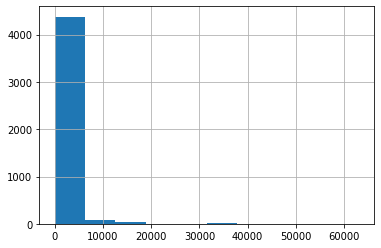

In [10]:
res_control_1.revenue.hist()
print(stats.shapiro(res_control_1.revenue.sample(1000, random_state=17)))
# p-value < 0.5, распределение не является нормальным

ShapiroResult(statistic=0.2145727276802063, pvalue=0.0)


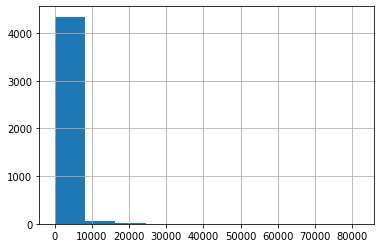

In [11]:
res_control_2.revenue.hist()
print(stats.shapiro(res_control_1.revenue.sample(1000, random_state=17)))
# p-value < 0.5, распределение не является нормальным

In [12]:
# подготовим данные и соберем полученную информацию в таблицу для наглядности
def get_metric_table(group1, group2, name_1, name_2):

    # количество пользователей в группах
    users_quantity_1 = group1.uid.nunique()
    users_quantity_2 = group2.uid.nunique()

    # выручка
    total_revenue_1 =  group1.revenue.sum()
    total_revenue_2 =  group2.revenue.sum()

    # количество покупок в группах
    checks_1_quantity = group1.query('revenue > 0').shape[0]
    checks_2_quantity = group2.query('revenue > 0').shape[0]

    # количество клиентов в группах
    clients_1_quantity = group1.query('revenue > 0').uid.nunique()
    clients_2_quantity = group2.query('revenue > 0').uid.nunique()

    # конверсия в покупателя
    cr_1 = round(clients_1_quantity / group1.shape[0] * 100, 2)
    cr_2 = round(clients_2_quantity / group2.shape[0] * 100 ,2)

    # средний чек
    avg_check_1 = round(group1.query('revenue > 0').revenue.mean(), 2)
    avg_check_2 = round(group2.query('revenue > 0').revenue.mean(), 2)

    # ARPU
    arpu_1 = round(group1.revenue.sum() / group1.shape[0], 2)
    arpu_2 = round(group2.revenue.sum() / group2.shape[0], 2)

    # ARPPU
    arppu_1 = round(group1.revenue.sum() / clients_1_quantity, 2)
    arppu_2 = round(group2.revenue.sum() / clients_2_quantity, 2)

    # коэффициент повторных покупок
    rep_purch_1 = round(checks_1_quantity / clients_1_quantity, 2)
    rep_purch_2 = round(checks_2_quantity / clients_2_quantity, 2)

    df = pd.DataFrame({'group': [name_1, name_2],
                       'users': [users_quantity_1, users_quantity_2],
                       'clients': [clients_1_quantity, clients_2_quantity],
                       'total_revenue': [total_revenue_1, total_revenue_2],
                       'cr': [cr_1, cr_2],
                       'avg_check': [avg_check_1, avg_check_2],
                       'arpu': [arpu_1, arpu_2],
                       'arppu': [arppu_1, arppu_2],
                       'rep_purch': [rep_purch_1, rep_purch_2]}
                     )

    return df

In [13]:
metrics_AA = get_metric_table(res_control_1, res_control_2, "control_1", "control_2").set_index("group").T
metrics_AA['diff'] = metrics_AA['control_2'] - metrics_AA['control_1']
metrics_AA['percent_diff'] = round(metrics_AA['diff'] / metrics_AA['control_1'] * 100, 2)
metrics_AA

group,control_1,control_2,diff,percent_diff
users,4340.00,4264.00,-76.00,-1.75
clients,193.00,187.00,-6.00,-3.11
total_revenue,2612311.00,1920438.00,-691873.00,-26.49
cr,4.27,4.25,-0.02,-0.47
avg_check,6929.21,5854.99,-1074.22,-15.50
arpu,577.43,435.97,-141.46,-24.50
arppu,13535.29,10269.72,-3265.57,-24.13
rep_purch,1.95,1.75,-0.20,-10.26


Проведем ряд тестов для выявления стат.значимости в полученных метриках:

1. Конверсия в платеж:

In [14]:
# для проверки стат.значимости СR воспользуемся proportions_ztest
def ztest(count, nobs):
    count = np.array(count)
    nobs = np.array(nobs)
    # np.array([group_a.query('revenue > 0').user_id.nunique(), group_b.query('revenue > 0').user_id.nunique()])
    # np.array([group_a.user_id.nunique(), group_b.user_id.nunique()])
    z,p = proportions_ztest(count, nobs, value=0, alternative='two-sided')
    print(' z-stat = {z} \n p-value = {p}'.format(z=z,p=p))

In [15]:
count = [res_control_1.query('revenue > 0').uid.nunique(), res_control_2.query('revenue > 0').uid.nunique()]
nobs = [res_control_1.uid.nunique(), res_control_2.uid.nunique()]
ztest(count, nobs)

 z-stat = 0.1387075944418351 
 p-value = 0.8896812166210464


По результатам proportions_ztest стат.значимых различий в конверсии контрольных групп нет. 

2. ARPU:

In [16]:
# Проведем А/А-тест:
def get_AA(df1, df2, n_s):
    
    simulations = 2000
    n_s = n_s
    res = []

    # Запуск симуляций A/A теста
    for i in tqdm(range(simulations)):
        s1 = df1.sample(n_s, replace=False).values
        s2 = df2.sample(n_s, replace=False).values
        res.append(stats.ttest_ind(s1, s2, equal_var=False)[1]) # сохраняем pvalue

    plt.hist(res, bins=50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title("Histogram of ttest A/A simulations ")
    plt.show()
    
    return sum(np.array(res) < 0.05) / simulations 

  0%|          | 0/2000 [00:00<?, ?it/s]

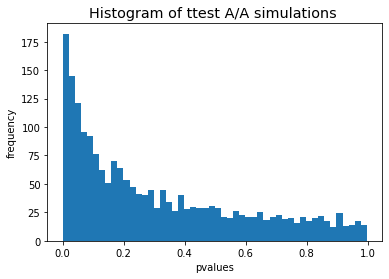

0.198

In [17]:
get_AA(res_control_1.revenue,
       res_control_2.revenue,
      1000)

  0%|          | 0/2000 [00:00<?, ?it/s]

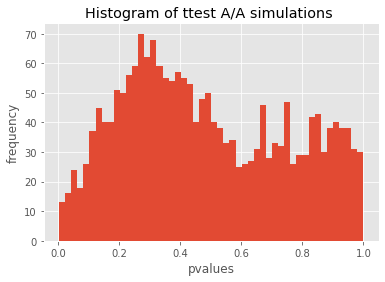

0.0185

In [18]:
get_AA(res_control_1.drop_duplicates(subset='uid').total_revenue,
       res_control_2.drop_duplicates(subset='uid').total_revenue,
      1000)

3. ARPPU:

  0%|          | 0/2000 [00:00<?, ?it/s]

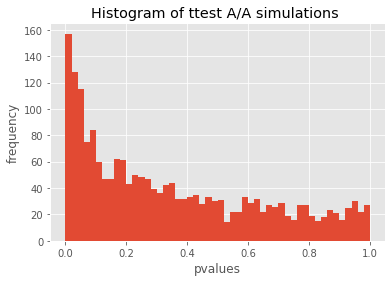

0.174

In [19]:
get_AA(res_control_1.query('revenue > 0').revenue,
       res_control_2.query('revenue > 0').revenue,
      100)

  0%|          | 0/2000 [00:00<?, ?it/s]

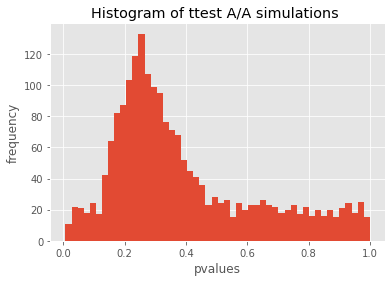

0.0185

In [20]:
get_AA(res_control_1.drop_duplicates(subset='uid').query('total_revenue > 0').total_revenue,
       res_control_2.drop_duplicates(subset='uid').query('total_revenue > 0').total_revenue,
      100)

FPR превышает альфа(0.05) в обоих случаях сравнения "revenue". Стоит поискать аномалии в данных о транзакциях, в противном случае непонятно, какую из тестовых групп включать в A/B-тестирование.


In [21]:
np.percentile(res_control_1.revenue, [90, 95, 99])
# Не более 1% процента пользователей совершали транзакции на суммы более чем 12727

array([    0.,  3913., 12727.])

In [22]:
res_control_1.query('revenue > 12727').sort_values(by='revenue', ascending=False)

,uid,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,country_y,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
2408,892216461,2017-10-18 14:41:00,2017-10-18 15:02:00,63037.0,147.0,autoreply_message,premium_no_trial,19,293,6.0,United States of America,"1,2,3,5,8,9,11,13,15,16,17,18,19,20,22,23,24,2...",1,16,25,58,1.0,1.0,64298.0
895,891383310,2017-04-11 20:47:00,2017-04-11 22:17:00,63037.0,147.0,autoreply_message,premium_no_trial,22,1000,NaN,Turkey,1,1,19,83,4,1.0,1.0,63037.0
1478,892333905,2017-10-16 01:38:00,2017-10-16 13:10:00,63037.0,147.0,no_sympathy,premium_no_trial,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
295,892421277,2017-10-14 13:05:00,2017-10-15 13:11:00,47723.0,147.0,promo_09,premium_no_trial,22,446,62.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,35,130,1.0,1.0,60333.0
1480,892333905,2017-10-16 01:38:00,2017-10-17 02:23:00,31525.0,19.0,menu,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
1491,892333905,2017-10-16 01:38:00,2017-10-17 20:53:00,31525.0,19.0,menu,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
1490,892333905,2017-10-16 01:38:00,2017-10-16 02:52:00,31525.0,19.0,menu,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
1489,892333905,2017-10-16 01:38:00,2017-10-16 10:24:00,31525.0,19.0,menu,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
1488,892333905,2017-10-16 01:38:00,2017-10-16 02:26:00,31525.0,19.0,menu,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
1487,892333905,2017-10-16 01:38:00,2017-10-16 02:26:00,31525.0,19.0,menu,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0


In [23]:
res_control_1.query('uid == 892333905')

,uid,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,country_y,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
1467,892333905,2017-10-16 01:38:00,2017-10-16 02:08:00,12610.0,19.0,gifts,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
1468,892333905,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
1469,892333905,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
1470,892333905,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
1471,892333905,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
1472,892333905,2017-10-16 01:38:00,2017-10-16 01:42:00,3783.0,67.0,menu,other_type,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
1473,892333905,2017-10-16 01:38:00,2017-10-16 22:35:00,31525.0,19.0,menu,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
1474,892333905,2017-10-16 01:38:00,2017-10-16 18:42:00,31525.0,19.0,fans,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
1475,892333905,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0
1476,892333905,2017-10-16 01:38:00,2017-10-16 22:39:00,19773.0,146.0,menu,coins,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330.0


Среди всех выделяются несколько пользователей, производивших транзакции на большие суммы.
Особенно пользователь "892333905", сделавший за двое суток 27 транзакций на суммы, значительно превышающие среднюю по контрольной группе.
Исключим его из датафрейма для сравнений транзакций.

In [24]:
round(res_control_1.query('uid == 892333905').revenue.sum() / res_control_1.revenue.sum()*100, 2)

18.62

Сумма транзакций пользователя '892333905' составляет 18.62% от всех транзакций первой контрольной группы.

In [25]:
res_control_1 = res_control_1.query('uid != 892333905')

In [26]:
np.percentile(res_control_2.revenue, [90, 95, 99])
# Не более 1% процентов пользователей совершали транзакции на суммы более чем 10390.12

array([    0.  ,  3580.2 , 10390.12])

In [27]:
res_control_2.query('revenue > 10390.12').sort_values(by='revenue', ascending=False)

,uid,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,country_y,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
1426,891778551,2017-10-27 21:26:00,2017-10-27 22:30:00,81796.0,147.0,left_sidebar_menu,premium_no_trial,30,290,NaN,United Arab Emirates,"1,6,7,8,9,10",1,27,33,31,1.0,1.0,81796
1274,892307238,2017-10-16 16:01:00,2017-10-16 20:41:00,63037.0,147.0,left_sidebar_menu,premium_no_trial,29,543,43.0,Spain,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,36,46,1.0,1.0,75647
938,891664350,2017-10-30 00:21:00,2017-03-11 02:57:00,19513.0,146.0,empty_likes,coins,34,242,271.0,Germany,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16",1,17,41,541,1.0,1.0,28119
3759,891328884,2017-05-11 17:44:00,2017-11-13 19:45:00,16952.0,147.0,trial_vip_popup,trial_premium,44,0,NaN,Italy,"1,2,4,5,7,8,9",1,41,47,0,1.0,1.0,16952
3712,891950754,2017-10-24 06:24:00,2017-10-31 08:39:00,16913.0,147.0,left_sidebar_menu,trial_premium,34,151,NaN,Portugal,"1,2,3,5,7,9,10,11",1,16,56,33,1.0,1.0,16913
4092,892215174,2017-10-18 15:17:00,2017-10-25 17:17:00,16835.0,147.0,trial_vip_popup,trial_premium,41,0,NaN,Belgium,1,1,38,44,4,1.0,1.0,16835
2834,891436977,2017-03-11 20:48:00,2017-10-11 22:48:00,16666.0,147.0,trial_vip_popup,trial_premium,43,571,NaN,Spain,"1,2",1,23,36,7,1.0,1.0,16666
1575,891962115,2017-10-23 22:53:00,2017-10-31 00:54:00,16653.0,147.0,trial_vip_popup,trial_premium,44,222,NaN,Spain,NaN,1,41,47,9,1.0,1.0,16653
1321,891985866,2017-10-23 13:19:00,2017-10-30 15:35:00,16640.0,147.0,trial_vip_popup,trial_premium,34,349,4.0,Belgium,"1,2,3,4,5,6,7,8,10,11,12,14,16,17,19,21,22",1,21,99,63,1.0,1.0,20605
2672,891691062,2017-10-29 16:19:00,2017-05-11 18:35:00,16614.0,147.0,popular_users_block,trial_premium,30,0,NaN,Belgium,1,1,27,33,0,1.0,1.0,16614


Во второй контрольной группе заметных выбросов или аномалий не наблюдается.

Проведем A/A-тест повторно.

In [28]:
metrics_AA = get_metric_table(res_control_1, res_control_2, "control_1", "control_2").set_index("group").T
metrics_AA['diff'] = metrics_AA['control_2'] - metrics_AA['control_1']
metrics_AA['percent_diff'] = round(metrics_AA['diff'] / metrics_AA['control_1'] * 100, 2)
metrics_AA

group,control_1,control_2,diff,percent_diff
users,4339.00,4264.00,-75.00,-1.73
clients,192.00,187.00,-5.00,-2.60
total_revenue,2125981.00,1920438.00,-205543.00,-9.67
cr,4.27,4.25,-0.02,-0.47
avg_check,6074.23,5854.99,-219.24,-3.61
arpu,472.76,435.97,-36.79,-7.78
arppu,11072.82,10269.72,-803.10,-7.25
rep_purch,1.82,1.75,-0.07,-3.85


1. Конверсия в платеж:

In [29]:
count = [res_control_1.query('revenue > 0').uid.nunique(), res_control_2.query('revenue > 0').uid.nunique()]
nobs = [res_control_1.uid.nunique(), res_control_2.uid.nunique()]
ztest(count, nobs)

 z-stat = 0.08910163611931635 
 p-value = 0.9290011371333468


По результатам proportions_ztest стат.значимых различий в конверсии контрольных групп нет. 

2. ARPU:

  0%|          | 0/2000 [00:00<?, ?it/s]

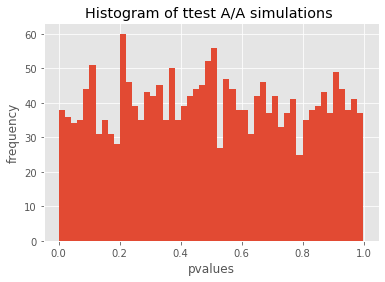

0.045

In [30]:
get_AA(res_control_1.revenue,
       res_control_2.revenue,
      1000)

  0%|          | 0/2000 [00:00<?, ?it/s]

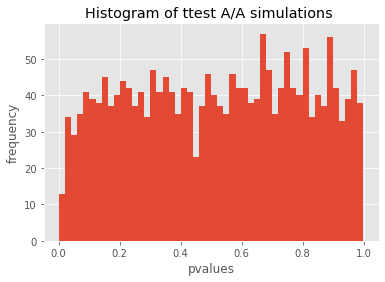

0.031

In [31]:
get_AA(res_control_1.drop_duplicates(subset='uid').total_revenue,
       res_control_2.drop_duplicates(subset='uid').total_revenue,
      1000)

3. ARPPU:

  0%|          | 0/2000 [00:00<?, ?it/s]

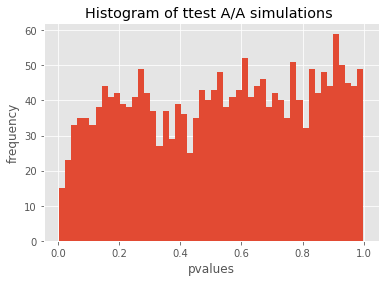

0.0225

In [32]:
get_AA(res_control_1.query('revenue > 0').revenue,
       res_control_2.query('revenue > 0').revenue,
      100)

  0%|          | 0/2000 [00:00<?, ?it/s]

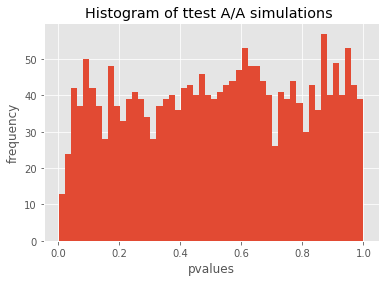

0.0295

In [33]:
get_AA(res_control_1.drop_duplicates(subset='uid').query('total_revenue > 0').total_revenue,
       res_control_2.drop_duplicates(subset='uid').query('total_revenue > 0').total_revenue,
      100)

FPR < 0.05. Исключив пользователя "892333905", мы добились того, что А/А-тест "сошёлся".
Можно предположить, что причина найдена.

## 3. Сравнения контрольной группы №1 и тестовой группы

Для начала проверим на наличие аномалий в тестовой группе.

[    0.   2022.8 12727. ]


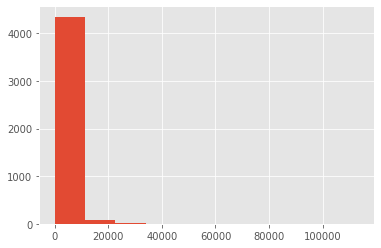

In [34]:
res_test.revenue.hist()
print(np.percentile(res_test.revenue, [90, 95, 99]))

In [35]:
res_test.query('revenue > 12727').sort_values(by='revenue', ascending=False)

,uid,joined_at,paid_at,revenue,payment_id,from_page,product_type,age,attraction_coeff,coins,country_y,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
1045,892038759,2017-10-22 11:12:00,2017-10-22 16:23:00,113477.0,147.0,autoreply_message,premium_no_trial,26,323,3.0,United Arab Emirates,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,23,48,232,1.0,1.0,123565
3742,891178380,2017-08-11 03:54:00,2017-09-11 21:53:00,113477.0,147.0,promo_09,premium_no_trial,42,275,85.0,Spain,"1,2,4,5,6,7",1,26,36,287,1.0,1.0,129870
2153,892275462,2017-10-17 05:56:00,2017-02-11 18:24:00,44083.0,19.0,coins_popup,other_type,31,310,NaN,France,"1,2,3,4,5,9,13,15,16",1,36,68,58,1.0,1.0,14885
1375,892150854,2017-10-20 00:25:00,2017-10-30 02:14:00,31525.0,19.0,empty_likes,coins,38,329,204.0,Argentina,"1,2,3,4,5,6,10,11,12,13,14,15,16,17,18,19,20,2...",1,35,41,231,1.0,1.0,61789
3430,892248561,2017-10-17 20:06:00,2017-10-18 20:35:00,31525.0,19.0,empty_likes,coins,22,106,192.0,Germany,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,16,26,198,1.0,1.0,38779
426,892236423,2017-10-18 01:09:00,2017-10-23 00:14:00,31525.0,19.0,menu,coins,23,262,378.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1...",1,19,23,1326,1.0,1.0,95823
2353,891914619,2017-10-24 23:12:00,2017-10-25 21:22:00,31525.0,19.0,empty_likes,coins,45,371,253.0,United States of America,"1,2,3,4",1,30,43,493,1.0,NaN,35308
633,891346269,2017-05-11 12:55:00,2017-07-11 11:28:00,31525.0,19.0,empty_likes,coins,34,204,530.0,Argentina,"1,2,3,4,5,6,7,9,10",1,16,37,44,1.0,1.0,75647
635,891346269,2017-05-11 12:55:00,2017-07-11 11:27:00,31525.0,19.0,empty_likes,coins,34,204,530.0,Argentina,"1,2,3,4,5,6,7,9,10",1,16,37,44,1.0,1.0,75647
1374,892150854,2017-10-20 00:25:00,2017-10-23 01:31:00,30264.0,68.0,super_popup,other_type,38,329,204.0,Argentina,"1,2,3,4,5,6,10,11,12,13,14,15,16,17,18,19,20,2...",1,35,41,231,1.0,1.0,61789


Явных аномалий не выявлено.

Проверим распределения на нормальность:

In [36]:
control = res_control_1.drop_duplicates(subset='uid').total_revenue
test = res_test.drop_duplicates(subset='uid').total_revenue
control

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4519    0.0
4520    0.0
4521    0.0
4522    0.0
4523    0.0
Name: total_revenue, Length: 4339, dtype: float64

ShapiroResult(statistic=0.1737847924232483, pvalue=0.0)


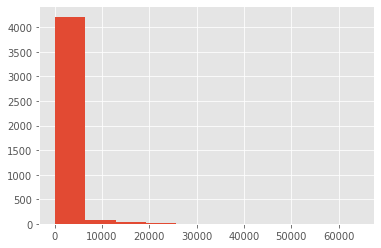

In [37]:
control.hist()
print(stats.shapiro(control.sample(1000, random_state=17)))

ShapiroResult(statistic=0.09746277332305908, pvalue=0.0)


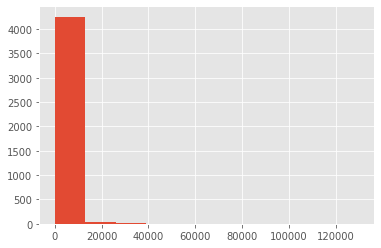

In [38]:
test.hist()
print(stats.shapiro(test.sample(1000, random_state=17)))

### 3.1. Создадим таблицу с метриками:

In [39]:
metrics = get_metric_table(res_control_1, res_test, "control_1", "test").set_index("group").T
metrics['diff'] = metrics['test'] - metrics['control_1']
metrics['percent_diff'] = round(metrics['diff'] / metrics['control_1'] * 100, 2)
metrics

group,control_1,test,diff,percent_diff
users,4339.00,4308.00,-31.00,-0.71
clients,192.00,146.00,-46.00,-23.96
total_revenue,2125981.00,2344901.00,218920.00,10.30
cr,4.27,3.29,-0.98,-22.95
avg_check,6074.23,8589.38,2515.15,41.41
arpu,472.76,528.73,55.97,11.84
arppu,11072.82,16060.97,4988.15,45.05
rep_purch,1.82,1.87,0.05,2.75


- Общая нормированная выручка в тестовой группе превосходит выручку в контрольной (после исключения пользователя "892333905") на 10.3%;


- При этом конверсия в платеж тестовой группы пользователей снизилась на ~23% относительно контрольной;

 
- ARPU в тестовой группе выше на 11.783%;


- ARPPU в тестовой группе заметно превосходит аналогичный показатель в контрольной, на ~45%;


- Cредний чек в тестовой группе дороже на ~41.4%.


### Проверим статистическую значимость различий между группами эксперимента.

### 3.2 Конверсия в платеж:

In [40]:
count = [res_test.query('revenue > 0').uid.nunique(), res_control_1.query('revenue > 0').uid.nunique()]
nobs = [res_test.uid.nunique(), res_control_1.uid.nunique()]
ztest(count, nobs)

 z-stat = -2.4852317141037985 
 p-value = 0.012946713330743232


#### По результатам proportions_ztest обнаружены стат.значимые различия в конверсии контрольной и тестовой групп. 

### 3.3. A/B-тест ARPU

Тест Шапиро-Уилка подтверждает, что распределения "revenue" контрольной и тестовых групп не являются нормальными.
Воспользуемся бутстрэпом. 

In [41]:
all_comparisons = pd.DataFrame(columns=['group', 'ci_0.025' , 'ci_0.0975', 'p_value'])

Определим гипотезы:
    
H0: Изменение стоимости премиум-подписки не повлияло на величины транзакций в контрольной и тестовой группах.

H1: Величины транзакций в контрольной и тестовой группах изменились вследствие изменения стоимости премиум-подписки.

In [42]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [43]:
boot_data_mean = get_bootstrap(test, control)

comparison_table = pd.DataFrame(columns=['group', 'ci_0.025' , 'ci_0.0975', 'p_value'])
p_value = boot_data_mean["p_value"]
ci_0025 = boot_data_mean["ci"].reset_index().loc[0][0]
ci_0975 = boot_data_mean["ci"].reset_index().loc[1][0]
comparison = {'group': "arpu",
              'ci_0.025': ci_0025,
              'ci_0.0975': ci_0975,
              'p_value': p_value}

comparison_table = comparison_table.append([comparison]) # соберем все сравнения в один df
        
# comparison_table['Bonferroni Correction Result'] = bonferroni(comparison_table.p_value, alpha = 0.05)
all_comparisons = all_comparisons.append(comparison_table)
comparison_table

  0%|          | 0/1000 [00:00<?, ?it/s]

,group,ci_0.025,ci_0.0975,p_value
0,arpu,-98.854604,208.290695,0.59415


Значение p-value больше "0.05", результаты сравнения не дают основания отклонить нулевую гипотезу.

** Здесь и далее все промежуточные выводы по результатам A/B-тестов основываются на скорректированном значении α. Полная таблица представлена в конце ноутбука.

### 3.3. A/B-тест ARPPU

In [44]:
control = res_control_1.query('revenue > 0').revenue
test = res_test.query('revenue > 0').revenue

boot_data_mean = get_bootstrap(test, control)

comparison_table = pd.DataFrame(columns=['group', 'ci_0.025' , 'ci_0.0975', 'p_value'])
p_value = boot_data_mean["p_value"]
ci_0025 = boot_data_mean["ci"].reset_index().loc[0][0]
ci_0975 = boot_data_mean["ci"].reset_index().loc[1][0]
comparison = {'group': 'arppu',
              'ci_0.025': ci_0025,
              'ci_0.0975': ci_0975,
              'p_value': p_value}

comparison_table = comparison_table.append([comparison])
        
# comparison_table['Bonferroni Correction Result'] = bonferroni(comparison_table.p_value, alpha = 0.05)
all_comparisons = all_comparisons.append(comparison_table)
comparison_table

  0%|          | 0/1000 [00:00<?, ?it/s]

,group,ci_0.025,ci_0.0975,p_value
0,arppu,1278.473857,3862.970429,0.000168


Можно сделать вывод о статистически значимом различии величин между контрольной и тестовой группами,
а также о положительной разнице величин транзакций платящих пользователей тестовой и контрольной групп.

Далее рассмотрим подгруппы пользователей, исходя из изменений в стоимости продуктов, а именно:
- пользователей пробной подписки (в тестовой группе стоимость не изменилась)
- премиум-подписки (в тестовой группе стоимость изменилась)
- подписки за внутреннюю валюту и "other".

In [45]:
def comparisons(groups):
    
    global all_comparisons
    comparison_table = pd.DataFrame(columns=['group', 'ci_0.025' , 'ci_0.0975', 'p_value'])
    
    for group in groups:
        control = (
            res_control_1
            .query('total_revenue > 0')
            .query(group)
            .revenue
        )
        test = (
            res_test
            .query('total_revenue > 0')
            .query(group)
            .revenue
        )
        boot_data_mean = get_bootstrap(test, control)
        p_value = boot_data_mean["p_value"]
        ci_0025 = boot_data_mean["ci"].reset_index().loc[0][0]
        ci_0975 = boot_data_mean["ci"].reset_index().loc[1][0]
        comparison = {'group': group,
                      'ci_0.025': ci_0025,
                      'ci_0.0975': ci_0975,
                      'p_value': p_value}

        comparison_table = comparison_table.append([comparison])
        
    # comparison_table['Bonferroni Correction Result'] = bonferroni(comparison_table.p_value, alpha = 0.05)
    all_comparisons = all_comparisons.append(comparison_table)
    return comparison_table

In [46]:
groups = ['product_type == "trial_premium"',
          'product_type == "premium_no_trial"',
          'product_type == "coins"',
          'product_type == "other_type"']
comparisons(groups)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,group,ci_0.025,ci_0.0975,p_value
0,"product_type == ""trial_premium""",557.860075,2137.049627,0.000710
0,"product_type == ""premium_no_trial""",475.227381,7754.400952,0.041946
0,"product_type == ""coins""",369.968843,2960.946455,0.010580
0,"product_type == ""other_type""",-426.171023,5433.239205,0.111006


Результаты после применения поправки:

- Обнаружены статистически значимые различия между контрольной и тестовой группами. Судя по доверительным интервалам, можно сделать предположение о положительном влиянии нововведений на ARRPU тестовой группы;

- Статистически значимые различия обнаружены только между пользователями контрольной и тестовой групп с пробной премиум-подпиской;

- Нет оснований отклонить нулевую гипотезу по нормированной выручке трех типов продукта: "premium_no_trial", "coins" и "other_type".

In [47]:
metrics

group,control_1,test,diff,percent_diff
users,4339.00,4308.00,-31.00,-0.71
clients,192.00,146.00,-46.00,-23.96
total_revenue,2125981.00,2344901.00,218920.00,10.30
cr,4.27,3.29,-0.98,-22.95
avg_check,6074.23,8589.38,2515.15,41.41
arpu,472.76,528.73,55.97,11.84
arppu,11072.82,16060.97,4988.15,45.05
rep_purch,1.82,1.87,0.05,2.75


#### Промежуточный итог: 

В целом, затруднительно судить об успешности эксперимента. Изменение стоимости премиум-подписки положительно сказалось на ARRPU (соответственно и на средний чек)  в тестовой группе. При этом коэффициент конверсии в плательщика в тестовой группе ниже на ~23% , чем в контрольной.

Увеличение стоимости премиум-подписки снизило количество желающих ее приобрести, но суммарная нормированная выручка выросла на 10.3% (правда с учетом исключения аномального пользователя).

In [48]:
print(res_test.paid_at.max() - res_test.joined_at.min())
print(res_test.joined_at.max() - res_test.joined_at.min())

334 days 18:59:00
293 days 20:33:00


Учитывая, что эксперимент длился достаточно продолжительный срок (около 300 дней), можно судить скорее о положительном влиянии нововведений.

## 4. Анализ влияния нововведений для конкретных групп пользователей.

In [49]:
res_control_1 = res_control_1.query('product_type == "trial_premium"')
res_test = res_test.query('product_type == "trial_premium"')

Разделим группы по следующим критериям и проведем сравнения:

1. Пол 
2. Возраст
3. Коэффициент привлекательности
4. Количество посещений приложения после регистрации

### 4.1. Пол

In [50]:
res_control_1.drop_duplicates(subset='uid').gender.value_counts()

1    63
0     4
Name: gender, dtype: int64

In [51]:
res_test.drop_duplicates(subset='uid').gender.value_counts()

1    59
0     2
Name: gender, dtype: int64

Делить и сравнивать пользователей по полу нет возможности, т.к. подавляющее большинство пользователей в группах относятся к гендеру "1". В большинстве случаев основной доход дейтинговым приложениям приносит мужская аудитория. Скорее всего, наш случай не стал исключением.

### 4.2. Возраст

Поделим пользователей по квартилям и сравним полученные группы между собой.

In [52]:
# исключил пользователей 99+, т.к. очень мала вероятность, что этот возраст достоверен
res_test.drop_duplicates(subset='uid').query('age < 99').age.quantile([0.25, 0.5, 0.75])

0.25    26.0
0.50    33.0
0.75    37.0
Name: age, dtype: float64

In [53]:
# исключил пользователей 99+, т.к. очень мала вероятность, что этот возраст достоверен
groups = ['age <= 26',
          'age >  26 and age <= 33',
          'age > 33 and age <= 37',
          'age > 37 and age < 99']
comparisons(groups)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,group,ci_0.025,ci_0.0975,p_value
0,age <= 26,84.773684,3076.227632,0.042247
0,age > 26 and age <= 33,-54.967391,2632.330435,0.053509
0,age > 33 and age <= 37,-355.815909,2191.386364,0.184284
0,age > 37 and age < 99,-144.402632,3196.032895,0.080727


#### Стат.значимые различия при скорректированном значении alpha обнаружены не были.

### 4.3 Коэффициент привлекательности

Как и в предыдущем пункте, для деления на подгруппы по коэффициенту привлекательности воспользуемся значениями квартилей тестовой группы пользователей.

In [54]:
res_test.drop_duplicates(subset='uid').attraction_coeff.quantile([0.25, 0.5, 0.75])

0.25    181.0
0.50    333.0
0.75    487.0
Name: attraction_coeff, dtype: float64

In [55]:
groups = ['attraction_coeff <= 181',
          'attraction_coeff > 181 and attraction_coeff <= 333',
          'attraction_coeff > 333 and attraction_coeff <= 487',
          'attraction_coeff > 487']
comparisons(groups)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,group,ci_0.025,ci_0.0975,p_value
0,attraction_coeff <= 181,-835.331250,2399.865000,0.350185
0,attraction_coeff > 181 and attraction_coeff <=...,473.486000,3205.163000,0.007246
0,attraction_coeff > 333 and attraction_coeff <=...,-26.823333,2613.931667,0.039229
0,attraction_coeff > 487,135.048333,3213.036667,0.039578


#### Стат.значимые различия при скорректированном значении alpha обнаружены не были.

### 4.4 Посещения после регистрации

Рассчитаем количество дней после регистрации, когда пользователь посещал приложение:

In [56]:
res_control_1['visit_days_count'] = res_control_1['visit_days'].str.split(",").str.len()
res_test['visit_days_count'] = res_test['visit_days'].str.split(",").str.len()
users_control_1['visit_days_count'] = users_control_1['visit_days'].str.split(",").str.len()
users_test['visit_days_count'] = users_test['visit_days'].str.split(",").str.len()

res_test.visit_days_count.isna().sum()
# есть пользователи, совершавшие транзакции, но посещения которых не зафиксированы

14

In [57]:
res_test.drop_duplicates(subset='uid').visit_days_count.quantile([0.25, 0.5, 0.75])

0.25     2.0
0.50     7.0
0.75    12.0
Name: visit_days_count, dtype: float64

In [58]:
groups = ['visit_days_count <= 2',
          'visit_days_count > 2 and visit_days_count <= 7',
          'visit_days_count > 7 and visit_days_count <= 12',
          'visit_days_count > 12']
comparisons(groups)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,group,ci_0.025,ci_0.0975,p_value
0,visit_days_count <= 2,-163.258333,2590.748333,0.062555
0,visit_days_count > 2 and visit_days_count <= 7,982.526316,3262.914474,0.000672
0,visit_days_count > 7 and visit_days_count <= 12,-66.137500,3211.135417,0.052483
0,visit_days_count > 12,-1144.092857,3184.210714,0.328674


#### Величины нормированной выручки среди умеренно активной части пользователей (3 - 7 дней посещений приложения после регистрации) в контрольной и тестовой группах значимо различаются в пользу тестовой.

In [59]:
query = 'visit_days_count > 2 and visit_days_count <= 7'
coeff_control = round(res_control_1.query(query).uid.nunique() /
                      users_control_1.query(query).shape[0] * 100, 2)
coeff_test = round(res_test.query(query).uid.nunique() /
                   users_test.query(query).shape[0] * 100, 2)
print("conversion_control = ", coeff_control, "%", sep="")
print("conversion_test = ", coeff_test, "%", sep="")

conversion_control = 1.96%
conversion_test = 1.21%


Значение коэффициента конверсии контрольной группы также превосходит аналогичный показатель в тестовой.

### Итоговая таблица всех сравнений

Воспользуемся поправками Холма-Бонферрони и Холма-Шидака для корректировки alpha в целях минимизации возможности получить ошибку первого рода при множественном сравнении средних:

In [60]:
all_comparisons['Holm-Bonferroni Correction Result'] = holm_bonferroni(all_comparisons.p_value, alpha=0.05)

reject, p_value_corrected, sidak_corr, bonf_corr = multipletests(all_comparisons.p_value, alpha=0.05, method='Holm-Sidak')
all_comparisons['Holm-Sidak Correction Result'] = reject

all_comparisons

,group,ci_0.025,ci_0.0975,p_value,Holm-Bonferroni Correction Result,Holm-Sidak Correction Result
0,arpu,-98.854604,208.290695,0.594150,False,False
0,arppu,1278.473857,3862.970429,0.000168,True,True
0,"product_type == ""trial_premium""",557.860075,2137.049627,0.000710,True,True
0,"product_type == ""premium_no_trial""",475.227381,7754.400952,0.041946,False,False
0,"product_type == ""coins""",369.968843,2960.946455,0.010580,False,False
0,"product_type == ""other_type""",-426.171023,5433.239205,0.111006,False,False
0,age <= 26,84.773684,3076.227632,0.042247,False,False
0,age > 26 and age <= 33,-54.967391,2632.330435,0.053509,False,False
0,age > 33 and age <= 37,-355.815909,2191.386364,0.184284,False,False
0,age > 37 and age < 99,-144.402632,3196.032895,0.080727,False,False


## Подведем итоги

1. Был ли эксперимент успешен в целом?

In [61]:
metrics

group,control_1,test,diff,percent_diff
users,4339.00,4308.00,-31.00,-0.71
clients,192.00,146.00,-46.00,-23.96
total_revenue,2125981.00,2344901.00,218920.00,10.30
cr,4.27,3.29,-0.98,-22.95
avg_check,6074.23,8589.38,2515.15,41.41
arpu,472.76,528.73,55.97,11.84
arppu,11072.82,16060.97,4988.15,45.05
rep_purch,1.82,1.87,0.05,2.75


В целом, можно судить об успешности эксперимента. Изменение стоимости премиум-подписки особенно заметно сказалось на ARRPU (соответственно и на средний чек) в тестовой группе. ARPU и ARPPU увеличились на 11.84% и 45% соответственно. При этом коэффициент конверсии в плательщика в тестовой группе ниже на ~23% , чем в контрольной.


Увеличение стоимости премиум-подписки снизило количество желающих ее приобрести, но суммарная нормированная выручка выросла на 10.3%. Прирост выручки в нашем случае можно трактовать в пользу тестовой группы.

2. Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

A/B-тестирования дают основания полагать, что изменение стоимости премиум-подписки без пробного периода статистически значимо повлияло:

- на пользователей, посещавших приложение 3 - 7 дней после регистрации*;



Во всех протестированных группах замечено снижение конверсии пользователей в плательщиков после введения изменений в цену премиум-подписки.